In [55]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import skimage
from PIL import Image
from detection_utils import *
from keypoint_utils import *

import importlib
from sklearn.metrics import mean_squared_error
import json
import yaml
import time
import supervision as sv
from inference import get_model
print(sv.__version__)


0.22.0


In [56]:
src="./videos/dbf_2.mp4"


In [57]:
model = get_model(
    model_id="football-ball-detection-rejhg/4", 
    api_key="fpgo7lotAA2MTZARBCtt"
)


In [58]:
model_keypoints = get_model(
    model_id="football-field-detection-f07vi/14", 
    api_key="fpgo7lotAA2MTZARBCtt"
)


In [59]:
import centroid_track
import detection_utils
import keypoint_utils
importlib.reload(centroid_track)
importlib.reload(detection_utils)
importlib.reload(keypoint_utils)
# Specify the path to the video file
video_path = src

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
else:
# Read the first frame
    pass

# Get video properties for output writer
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))




slice_dimensions = (640, 480)  # Width and height for slicing
overlap_dimensions = (100, 100)  # Overlap between slices
slice_wh=slice_dimensions
overlap_wh=overlap_dimensions

frame_number=0
# Initialize the BallTracker
tracker = centroid_track.BallTracker(buffer_size=5)


# Intialize DeepSort

ball_positions = []
yolo_detections=[]
first=False
all_frames=[]
frame_number=0
# Read all the frames
all_keypoints=[]
det_conf=0.4
keyp_conf=0.8
while True:
    ret, frame = cap.read()
    if not ret:
        break
    all_frames.append(frame)
    #Run ball detection inference on patches
    #patches = slice_frame(frame, slice_wh, overlap_wh)
    #detection_frame,det_ball = infer_on_patches(model, patches, frame_number,0.6,0.4)

    #Run ball detection inference on a single FRAME
    detection_frame=normal_prediction(model, frame, frame_number,0.6,0.4)

    print(" detection frame length is:  ",len(detection_frame))
    if len(detection_frame)>1:
        print("================Multiple BALL DETECTION==================")

    ## Run keypoint detection inference on single Frame

    kpoints = keypoint_utils.keypoint_prediction(model_keypoints,frame,det_conf,keyp_conf)
    all_keypoints.append(kpoints)


    det=False
    detections_track = []

    if isinstance(detection_frame, np.ndarray) and detection_frame.size > 0:  # Check if it's a NumPy array with elements
        print("inside the FIRST instance-----111")
        for dets in detection_frame:
            x1, y1, x2, y2, conf = dets
            x_centroid=(x1 + x2) // 2
            y_centroid=(y1 + y2) // 2
            detections_track.append([x_centroid,y_centroid ])  # Append the centroid
        detections_track = np.array(detections_track)
        tracked_ball = tracker.update(detections_track)

        ball_positions.append((tracked_ball[0], tracked_ball[1]))  # Store centroid
        det=True
    elif isinstance(detection_frame, list) and len(detection_frame) > 0:  # Check if it's a non-empty list
        for dets in detection_frame:
            x1, y1, x2, y2, conf = dets
            x_centroid=(x1 + x2) // 2
            y_centroid=(y1 + y2) // 2
            
            detections_track.append([x_centroid,y_centroid ]) 
        detections_track = np.array(detections_track)
        tracked_ball = tracker.update(detections_track)
        ball_positions.append((tracked_ball[0], tracked_ball[1]))  # Store centroid
        det=True
    else:
        print("Inside none tracker-------")
        tracked_ball = tracker.update(None)  
        ball_positions.append((np.nan,np.nan))
        det=False
    print("The ball position is: ",ball_positions)
    print("The frame number is :",frame_number)
    frame_number+=1
    if frame_number==20:
        break
# Release the video capture object
cap.release()



        




 detection frame length is:   1
The predictions are:  [KeypointsPrediction(x=959.5, y=705.5, width=1919.0, height=749.0, confidence=0.9832988977432251, class_name='pitch', class_confidence=None, class_id=0, tracker_id=None, detection_id='6716c787-9e5d-4e0a-bfbe-1c939e3e0bda', parent_id=None, keypoints=[Keypoint(x=16.0, y=410.0, confidence=9.834766387939453e-07, class_id=0, class_name='01'), Keypoint(x=0.0, y=452.0, confidence=1.1920928955078125e-07, class_id=1, class_name='02'), Keypoint(x=0.0, y=523.0, confidence=5.960464477539063e-08, class_id=2, class_name='03'), Keypoint(x=0.0, y=697.0, confidence=0.0, class_id=3, class_name='04'), Keypoint(x=0.0, y=715.0, confidence=0.0, class_id=4, class_name='05'), Keypoint(x=1000.0, y=827.0, confidence=8.940696716308594e-08, class_id=5, class_name='06'), Keypoint(x=0.0, y=527.0, confidence=8.940696716308594e-08, class_id=6, class_name='07'), Keypoint(x=0.0, y=649.0, confidence=2.9802322387695312e-08, class_id=7, class_name='08'), Keypoint(x=0.0

In [61]:
yolo=False
df_positions = pd.DataFrame(ball_positions, columns=["x", "y"])
df_positions = df_positions.interpolate(method="linear").bfill()  # Interpolate missing values
position_array=list(df_positions.values)

# Define the codec and create VideoWriter object
output_path = './videos/dbf_2_out.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'MP4V' for MP4 files
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

for current_positions,frame in zip(position_array,all_frames):
 
    

    # Get the current interpolated position for this frame
    x, y = current_positions
    
    if not np.isnan(x) and not np.isnan(y):
        
        x, y = int(x), int(y)
        # Draw interpolated circle
        cv2.circle(frame, (x, y), radius=10, color=(0, 0, 255), thickness=2)

    #Draw raw detections from YOLO
    if yolo:

        x1=int(x1)
        x2=int(x2)
        y1=int(y1)
        y2=int(y2)
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
        x,y,w,h=xyxy2xywh(x1,y1,x2,y2)






    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    out.write(frame)
    

In [62]:
position_array[0]

array([        681,         651])

keypoints adta is:  {'keypoints': (1052.0, 421.0), 'class': '20', 'conf': 0.9998083710670471}
keypoints adta is:  {'keypoints': (1192.0, 489.0), 'class': '21', 'conf': 0.9999188184738159}
keypoints adta is:  {'keypoints': (1414.0, 596.0), 'class': '22', 'conf': 0.9989910125732422}
keypoints adta is:  {'keypoints': (1677.0, 723.0), 'class': '23', 'conf': 0.9539748430252075}
keypoints adta is:  {'keypoints': (1477.0, 528.0), 'class': '24', 'conf': 0.9985800981521606}
keypoints adta is:  {'keypoints': (1508.0, 463.0), 'class': '25', 'conf': 0.9984670281410217}
keypoints adta is:  {'keypoints': (1840.0, 586.0), 'class': '26', 'conf': 0.8093938231468201}
keypoints adta is:  {'keypoints': (1335.0, 347.0), 'class': '27', 'conf': 0.9914171695709229}
keypoints adta is:  {'keypoints': (1496.0, 402.0), 'class': '28', 'conf': 0.9965713620185852}
keypoints adta is:  {'keypoints': (1661.0, 456.0), 'class': '29', 'conf': 0.9870901703834534}
keypoints adta is:  {'keypoints': (289.0, 601.0), 'class': '

True

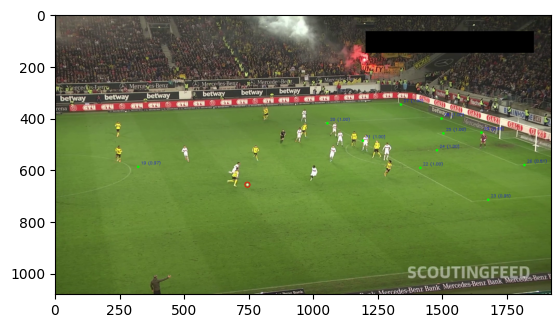

In [92]:
import centroid_track
import detection_utils
import keypoint_utils
importlib.reload(centroid_track)
importlib.reload(detection_utils)
importlib.reload(keypoint_utils)
keypoint_frames=keypoint_utils.draw_keypoints(all_keypoints,all_frames)
plt.figure()

plt.imshow(keypoint_frames[10])
cv2.imwrite("keypoints_field.png", keypoint_frames[0])

In [93]:
from soccer_config import SoccerPitchConfiguration
import keypoint_homography
from keypoint_homography import Transform
CONFIG = SoccerPitchConfiguration()

In [94]:
index_frame_number=10

In [95]:
vert=CONFIG.vertices
print(vert)

[(0, 0), (0, 1450.0), (0, 2584.0), (0, 4416.0), (0, 5550.0), (0, 7000), (550, 2584.0), (550, 4416.0), (1100, 3500.0), (2015, 1450.0), (2015, 2584.0), (2015, 4416.0), (2015, 5550.0), (6000.0, 0), (6000.0, 2585.0), (6000.0, 4415.0), (6000.0, 7000), (9985, 1450.0), (9985, 2584.0), (9985, 4416.0), (9985, 5550.0), (10900, 3500.0), (11450, 2584.0), (11450, 4416.0), (12000, 0), (12000, 1450.0), (12000, 2584.0), (12000, 4416.0), (12000, 5550.0), (12000, 7000), (5085.0, 3500.0), (6915.0, 3500.0)]


In [96]:
len(all_keypoints)

20

In [97]:
kpts=all_keypoints[index_frame_number]
print(kpts)

[{'keypoints': (1052.0, 421.0), 'class': '20', 'conf': 0.9998008012771606}, {'keypoints': (1189.0, 488.0), 'class': '21', 'conf': 0.9999196529388428}, {'keypoints': (1411.0, 593.0), 'class': '22', 'conf': 0.998815655708313}, {'keypoints': (1673.0, 716.0), 'class': '23', 'conf': 0.9498482942581177}, {'keypoints': (1475.0, 525.0), 'class': '24', 'conf': 0.9981720447540283}, {'keypoints': (1500.0, 460.0), 'class': '25', 'conf': 0.9981859922409058}, {'keypoints': (1813.0, 582.0), 'class': '26', 'conf': 0.8079389333724976}, {'keypoints': (1336.0, 349.0), 'class': '27', 'conf': 0.9951406717300415}, {'keypoints': (1493.0, 403.0), 'class': '28', 'conf': 0.996536374092102}, {'keypoints': (1647.0, 457.0), 'class': '29', 'conf': 0.9841142296791077}, {'keypoints': (321.0, 589.0), 'class': '19', 'conf': 0.9709161520004272}]


In [98]:
final_vert=[]
final_kpts=[]
for item in kpts:
    indx=int(item["class"])
    final_kpts.append(item["keypoints"])
    final_vert.append(vert[indx])

In [99]:
print("Final vertices are: ",final_vert)
print("Final keypoints are: ",final_kpts)

Final vertices are:  [(9985, 5550.0), (10900, 3500.0), (11450, 2584.0), (11450, 4416.0), (12000, 0), (12000, 1450.0), (12000, 2584.0), (12000, 4416.0), (12000, 5550.0), (12000, 7000), (9985, 4416.0)]
Final keypoints are:  [(1052.0, 421.0), (1189.0, 488.0), (1411.0, 593.0), (1673.0, 716.0), (1475.0, 525.0), (1500.0, 460.0), (1813.0, 582.0), (1336.0, 349.0), (1493.0, 403.0), (1647.0, 457.0), (321.0, 589.0)]


In [100]:
final_vert_array=np.array(final_vert)
final_kpts_array=np.array(final_kpts)

In [101]:

transformer = Transform(
    source=final_kpts_array.astype(np.float32),
    target=final_vert_array.astype(np.float32)
)


In [102]:
pts_2d=position_array[index_frame_number].reshape(1, -1) 

In [103]:

final_img=transformer.transform_points(points=pts_2d)

In [104]:
final_img

array([[      11283,      3659.4]], dtype=float32)

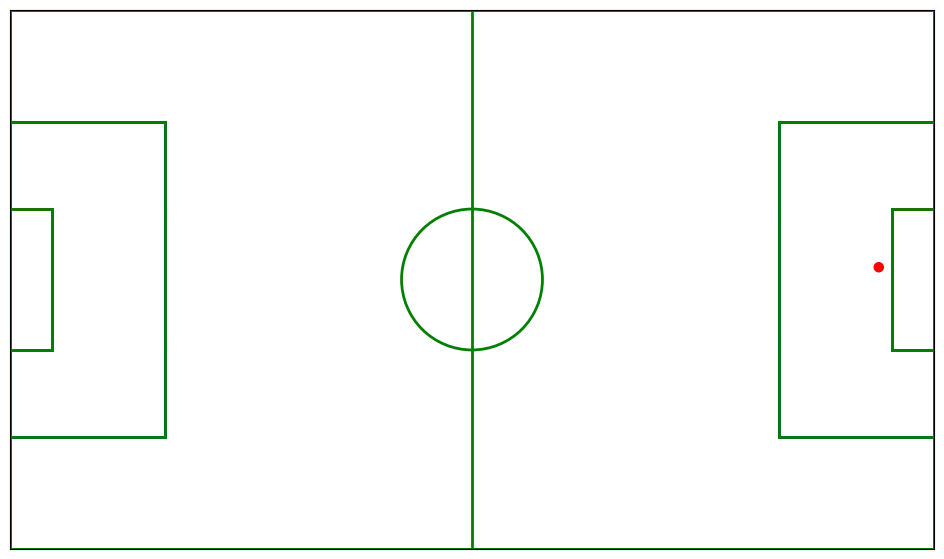

In [105]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from soccer_config import SoccerPitchConfiguration
pitch = SoccerPitchConfiguration()
fig, ax = plt.subplots(figsize=(12, 7))

# Set the axis limits
ax.set_xlim(0, pitch.length)
ax.set_ylim(0, pitch.width)

# Plot the outer boundary of the field
field_outline = patches.Rectangle((0, 0), pitch.length, pitch.width, linewidth=2, edgecolor="green", facecolor="none")
ax.add_patch(field_outline)

# Plot the centre circle
centre_circle = patches.Circle((pitch.length / 2, pitch.width / 2), pitch.centre_circle_radius, linewidth=2, edgecolor="green", facecolor="none")
ax.add_patch(centre_circle)

# Plot the penalty boxes
penalty_box1 = patches.Rectangle((0, (pitch.width - pitch.penalty_box_width) / 2), pitch.penalty_box_length, pitch.penalty_box_width, linewidth=2, edgecolor="blue", facecolor="none")
penalty_box2 = patches.Rectangle((pitch.length - pitch.penalty_box_length, (pitch.width - pitch.penalty_box_width) / 2), pitch.penalty_box_length, pitch.penalty_box_width, linewidth=2, edgecolor="blue", facecolor="none")
ax.add_patch(penalty_box1)
ax.add_patch(penalty_box2)

# Plot the goal boxes
goal_box1 = patches.Rectangle((0, (pitch.width - pitch.goal_box_width) / 2), pitch.goal_box_length, pitch.goal_box_width, linewidth=2, edgecolor="red", facecolor="none")
goal_box2 = patches.Rectangle((pitch.length - pitch.goal_box_length, (pitch.width - pitch.goal_box_width) / 2), pitch.goal_box_length, pitch.goal_box_width, linewidth=2, edgecolor="red", facecolor="none")
ax.add_patch(goal_box1)
ax.add_patch(goal_box2)

# Plot the edges (lines connecting the vertices)
for edge in pitch.edges:
    x1, y1 = pitch.vertices[edge[0] - 1]
    x2, y2 = pitch.vertices[edge[1] - 1]
    ax.plot([x1, x2], [y1, y2], color="green", lw=2)
# Plot the ball at the transformed position (xy)
ball_x, ball_y = final_img[0]  # Extract the x, y position of the ball
ball_radius = 50  # Radius of the ball (adjust as needed)
ball = patches.Circle((ball_x, ball_y), ball_radius, linewidth=2, edgecolor="red", facecolor="red")
ax.add_patch(ball)

# Set aspect ratio and remove axis ticks
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()



The df positinos are:             x      y
0     681.00  651.0
1     681.00  651.0
2     689.00  653.0
3     697.50  656.0
4     706.00  659.0
..       ...    ...
395  1488.50  681.0
396  1485.25  682.0
397  1482.00  683.0
398  1480.00  683.0
399  1477.00  685.0

[400 rows x 2 columns]


The x y positioins are:  681.0 651.0
The x y positioins are:  681.0 651.0
The x y positioins are:  689.0 653.0
The x y positioins are:  697.5 656.0
The x y positioins are:  706.0 659.0
The x y positioins are:  713.0 657.0
The x y positioins are:  718.6666666666666 656.3333333333334
The x y positioins are:  724.3333333333334 655.6666666666666
The x y positioins are:  730.0 655.0
The x y positioins are:  737.0 656.0
The x y positioins are:  743.0 658.3333333333334
The x y positioins are:  749.0 660.6666666666666
The x y positioins are:  755.0 663.0
The x y positioins are:  761.0 665.0
The x y positioins are:  766.6666666666666 664.6666666666666
The x y positioins are:  772.3333333333334 664.3333333333334
The x y positioins are:  778.0 664.0
The x y positioins are:  784.0 665.0
The x y positioins are:  789.0 666.6666666666666
The x y positioins are:  794.0 668.3333333333334
The x y positioins are:  799.0 670.0
The x y positioins are:  807.0 670.0
The x y positioins are:  822.0 671.4
The x